<a href="https://colab.research.google.com/github/chrisfinan/GenAI/blob/main/HW4/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chris Finan
> 11/4/24

>Assignment 4

#Description
* In this project, you will build and train a Generative Adversarial Network (GAN) using the LSUN (Large-scale Scene Understanding) dataset, specifically focusing on the bedroom category. The goal is to train the GAN to generate realistic bedroom images based on the patterns learned from the training data.
* The total amount of time to run this code was around 2 hours.

## 0. Import Statements

In [1]:
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
)

In [2]:
tf.__version__

'2.17.0'

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## 1. Download the LSUN bedrooms dataset and preprocess the images for training.
* https://www.kaggle.com/datasets/jhoward/lsun_bedroom

In [5]:
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

# Paths
zip_file_path = '/content/drive/MyDrive/archive.zip'
extract_to = '/content/'

# Extract the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')

Mounted at /content/drive


['.config', 'drive', 'sample', 'data0', 'sample_data']

In [6]:
import random
import shutil

# Point to the dataset in the zip file and create a subset
dataset_dir = '/content/sample/data0/lsun/bedroom'
subset_dir = '/content/lsun_bedroom_subset'

# 50,000 images were used in the final analysis
num_images = 50000

# Create the subset directory
os.makedirs(subset_dir, exist_ok=True)

# Get a list of all image files in the dataset directory
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

# Randomly select images
selected_images = random.sample(image_files, min(num_images, len(image_files)))

# Copy selected images to the subset directory
for image in selected_images:
    shutil.copy(image, os.path.join(subset_dir, os.path.basename(image)))

# Check the number of images in the newly made subset
print(f"Num images in new subset: {len(selected_images)} images in {subset_dir}")

Num images in new subset: 50000 images in /content/lsun_bedroom_subset


In [7]:
# Parameters used
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 256
Z_DIM = 100
EPOCHS = 50

LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [8]:
train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "/content/lsun_bedroom_subset",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 50000 files.


In [9]:
# Normalize images to be between -1 and 1 for the GAN
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

## 2. Create the generator and discriminator models for the GAN architecture.

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │          12,288 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,981,824 (15.19 MB)

 Trainable params: 3,979,520 (15.18 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [14]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

## 3. Train the GAN on the bedrooms dataset, iteratively improving the generator's ability to produce realistic images and the discriminator's ability to distinguish between real and generated images.



In [16]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 106s 383ms/step - d_acc: 0.7766 - d_fake_acc: 0.7942 - d_loss: 0.3941 - d_real_acc: 0.7590 - g_acc: 0.2058 - g_loss: 2.4272
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 302ms/step - d_acc: 0.8219 - d_fake_acc: 0.8491 - d_loss: 0.3155 - d_real_acc: 0.7946 - g_acc: 0.1509 - g_loss: 2.0555
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 299ms/step - d_acc: 0.8522 - d_fake_acc: 0.8654 - d_loss: 0.2417 - d_real_acc: 0.8391 - g_acc: 0.1346 - g_loss: 2.2892
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - d_acc: 0.8175 - d_fake_acc: 0.8343 - d_loss: 0.3125 - d_real_acc: 0.8007 - g_acc: 0.1657 - g_loss: 2.2346
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 300ms/step - d_acc: 0.8638 - d_fake_acc: 0.8785 - d_loss: 0.1985 - d_real_acc: 0.8492 - g_acc: 0.1215 - g_loss: 2.6831
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 59s 300ms/step - d_acc: 0.8754 - d_fake_acc: 0.8799 - d_loss: 0.1445 - d_real_acc: 0.8710 - g_acc: 0.1201 - g_loss: 3.1378
Epoch 7/50
196/196 ━━

One thing I found interesting about the training was the variation in times for each epoch. Most took around 60 seconds or around 80 seconds only. It was also interesting to see the fluctuation in accuracies. Epoch 38 had 100% accuracy while epoch 39 had the lowest accuracy in the dataset. There were slight ups and downs, so there definitely could be improvements there and the model hasn't exactly reached convergence. Throughout training, it was generally headed in the right direction, so maybe small adjustments to the architecture or learning rate could be made to improve the training.

In [17]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [18]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


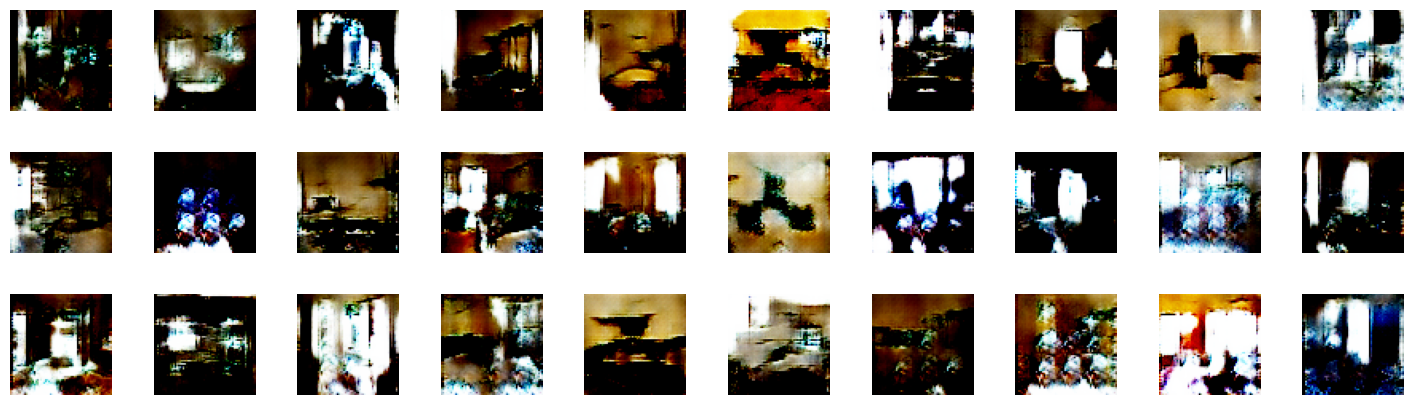

In [19]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

The decoded images are very similar to the generated images. It is possible to tell that they are bedrooms, but the detailed features are lacking.






## 4. After training, use the generator to create new, previously unseen images of bedrooms that resemble the training data.

In [20]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [21]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


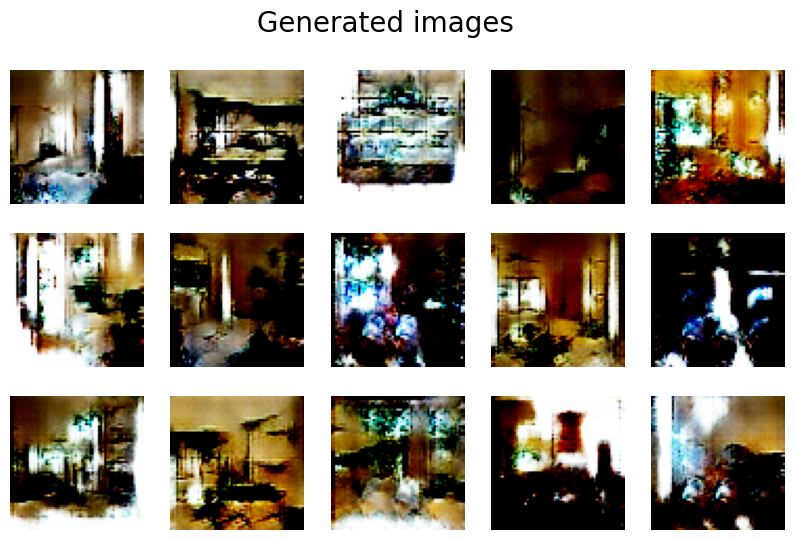

In [27]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt])
        axs[i, j].axis("off")
        cnt += 1

plt.show()

Discuss the trade-off between generating high-quality images and maintaining diversity in the output. Are the generated images too similar, or does the model capture a wide range of bedroom styles?

* Based on the generated images here, most of them are able to be easily distinguished from each other. However, they are not the most high quality images. To achieve greater diversity, the GAN needs to cover a broader range of images. Covering a broader range can lead to more diverse outputs,but lower quality images. In some cases, the generator can learn to produce similar outputs that constantly fool the discriminator, causing for less diversity and more similar images. A small subset can result with higher quality images that all look the same.

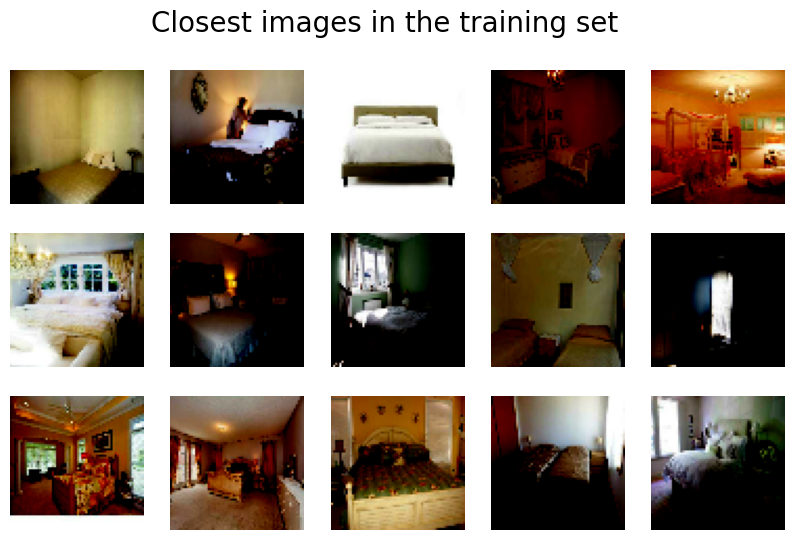

In [28]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img)
        axs[i, j].axis("off")
        cnt += 1

plt.show()

Looking at the closest images in the training set, the one that stands out the most is the middle row/last column. It is barely a room and looks just like a light. The generated image in the same location matches this one the best. Similarly, the one in the top middle lacks detail and is only just a bed. The generated image in the same spot looks like a very low quality bed. For this specific model, it seems that the dataset does much better with images with less details and tends to mesh features together in more intricate pictures.

Consider on potential enhancements to the model architecture or training process. Would experimenting with different hyperparameters or batch sizes yield better results?

* This GAN can definitely be further optimized to create higher quality images. To start, giving it a greater subset of images from the LSUN dataset will improve accuracy but will also increase training time. I attempted with 100,000 images but accidentally deleted the training results and crashed in future attempts to recreate it. I also attempted 200,000 images but Google did not like that and timed me out after 30 epochs. Using 50,000 images made it possible to recognize the images as looking like bedrooms. Using only 2,000 images yielded very poor results with unrecognizable images.
* Increasing the amount of epochs can also yield better results. Towards the end of the 50 epochs, some of the accuracies were increasing while the losses were still decreasing. Increasing this parameter slightly could improve the model without overfitting.
* Having a larger batch size can help improve training speed, but also may hurt diversity. Using a smaller batch size can help improve training stability and diversity.

What are the practical applications for this type of generative model?
* In addition to generating high quality images, GANs can also be used to improve the quality of medical scans like CT and MRI. GANs could also help generate textures in video games and movies to build an accurate landscape. GANs have also been used by OpenAI and Nvidia for realistic image generation. The GAN used here is only a small sample of what they are actually capable of.



Extra Credit Research Problem:  Consider how you might quantitatively evaluate the quality of the generated images.
Hint: Inception Score (IS) or Inception Distance (ID) can provide measures of image quality and diversity.
* To quantitatively evaluate the quality of the generated images, you must first make a function that calculates the quantitative values like inception score and inception distance. These scores could be compared to the actual dataset to help show the generator what it should strive to be. Inception score uses kl divergence to determine the diversity and quality of images. ID calculates the difference between two multivariate gaussians (1 for generated, 1 for real). The distance (commonly Wasserstein-2) is calculated alongside mean and covariance. ID can be more sensitive to variations in quality.

## 5. References
* https://github.com/bforoura/GenAI/blob/main/Module4/dcgan.ipynb
* https://github.com/bforoura/GenAI/blob/main/Module4/tf_dcgan.ipynb